based on : https://medium.com/python-data/efficient-frontier-portfolio-optimization-with-python-part-2-2-2fe23413ad94

## Modern Portfolio Theroy
- a hypothsis put forth by Harry Markowitz in his paper. is an investment theory based on the idea that risk-averse investors can construct portfolios to optimize ormaximize expected return basd on a given level of market risk, emphasizing that risk is an inherent part of higher reward. It is one of the most important and influential economic theories dealing with finance and investment.

- Also called "portfolio theory" or "portfolio management theory," MPT suggests that it is possible to construct an "efficient frontier" of optimal portfolios, offering the maximum possible expected return for a given level of risk. It suggests that it is not enough to look at the expected risk and return of one particular stock. By investing in more than one stock, an investor can reap the benefits of diversification, particularly a reduction in the riskiness of the portfolio. MPT quantifies the benefits of diversification, also known as not putting all of your eggs in one basket.

Read more: Modern Portfolio Theory (MPT) https://www.investopedia.com/walkthrough/fund-guide/introduction/1/modern-portfolio-theory-mpt.aspx#ixzz5RuCLiEyB 
Follow us: Investopedia on Facebook

In [13]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [63]:
# get adjusted closing prices of 5 selected companies with Quandl
quandl.ApiConfig.api_key = 'gnSakH2XhFbxzim6fzxs'
selected = ['CNP', 'F', 'WMT', 'GE', 'TSLA']
data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2014-1-1', 'lte': '2016-12-31' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2016-12-30,WMT,67.742045
1,2016-12-29,WMT,67.879254
2,2016-12-28,WMT,67.928257
3,2016-12-27,WMT,68.310482
4,2016-12-23,WMT,68.153672


In [64]:
clean = data.set_index('date')
table = clean.pivot(columns='ticker')
table.head()

adj_close                                         
ticker            CNP          F         GE    TSLA        WMT
date                                                          
2014-01-02  19.116238  12.726742  24.266002  150.10  71.343743
2014-01-03  19.107861  12.784441  24.248354  149.56  71.108673
2014-01-06  19.132992  12.842140  24.054226  147.00  70.710863
2014-01-07  19.334039  12.677286  24.080698  149.36  70.927850
2014-01-08  19.132992  12.809169  24.010106  151.28  70.367299

일별, 연별 수익과 공분산을 구한다.

In [65]:
# 위에서 구한 데이터 프레임의 변화도를 구한다.
returns_daily = table.pct_change()
display(returns_daily.tail())
returns_annual = returns_daily.mean() * 250

# 위에서 구한 데이터 프레임의 공분산을 구한다.
cov_daily = returns_daily.cov()
display(cov_daily)
cov_annual = cov_daily * 250

adj_close                                        
ticker           CNP         F        GE      TSLA       WMT
date                                                        
2016-12-23 -0.000403  0.004839  0.001886  0.023459 -0.000718
2016-12-27 -0.002819 -0.005618  0.000627  0.029015  0.002301
2016-12-28 -0.012924 -0.011299 -0.006270  0.000957 -0.005595
2016-12-29  0.011866 -0.001633  0.000315 -0.023027 -0.000721
2016-12-30 -0.003639 -0.008177 -0.003469 -0.004612 -0.002021

adj_close                                        
ticker                 CNP         F        GE      TSLA       WMT
          ticker                                                  
adj_close CNP     0.000164  0.000056  0.000061  0.000070  0.000042
          F       0.000056  0.000211  0.000086  0.000117  0.000046
          GE      0.000061  0.000086  0.000134  0.000089  0.000043
          TSLA    0.000070  0.000117  0.000089  0.000707  0.000051
          WMT     0.000042  0.000046  0.000043  0.000051  0.000129

In [29]:
# 수익률과 변동성 그리고 가중치를 저장하기 위한 빈 리스트를 준비한다.
port_returns = []
port_volatility = []
stock_weights = []

# 우리가 보고 있는 주식 데이터가 5개 (num_assets) 그리고 총 보유하려고 하는 포트폴리오 갯수를 5만개로 셋팅한다.
num_assets = len(selected)
num_portfolios = 50000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
# 가중치를 랜덤하게 뽑아서 비율의 형태로 만들어준다. 이때 가중치는 5개씩 리스트로 만들며 총 5만쌍을 만든다.
    returns = np.dot(weights, returns_annual)
    # 연별 수익률과 가중치를 곱해준다. 즉, 5개의 수익률이 가중치가 더해져서 다 더하면 1이 된다.
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    # 변동성은 (가중치 * 공분산 * 가중치) * 1/2 한다.
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)
    #이전에 저장해두었던 빈 리스트에 저장한다. 가중치가 더해진 수익률과 변동성이기 때문에, 포트폴리오 + ~가 된다.

portfolio = {'Returns': port_returns,
             'Volatility': port_volatility}
# 데이터 프레임에 넣어줄 것이기 때문에 딕셔너리 형태로 만들어준다. 딕셔너리의 키들이 데이터 프레임의 컬럼이 된다.

# 총 수익률 말고도 5개의 기업들에게 각각 할당된 가중치들이 총 Returns를 만든 것이기 때문에, 가중치도 이름을 더해
# 옆으로 하나씩 만들어준다. 가중치 갯수는 selected(5) 반복문에 stock_weights(50000) 이다.
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
df = df[column_order]

In [44]:
df.tail()

,Returns,Volatility,CNP Weight,F Weight,WMT Weight,GE Weight,TSLA Weight
49995,0.066560,0.149008,0.212655,0.180653,0.252349,0.119598,0.234745
49996,0.055107,0.165214,0.450609,0.397304,0.050886,0.057714,0.043486
49997,0.054731,0.161171,0.045162,0.349166,0.419085,0.064851,0.121735
49998,0.065233,0.206287,0.002493,0.447203,0.046531,0.312565,0.191208
49999,0.101460,0.173544,0.350344,0.144693,0.288223,0.209173,0.007568


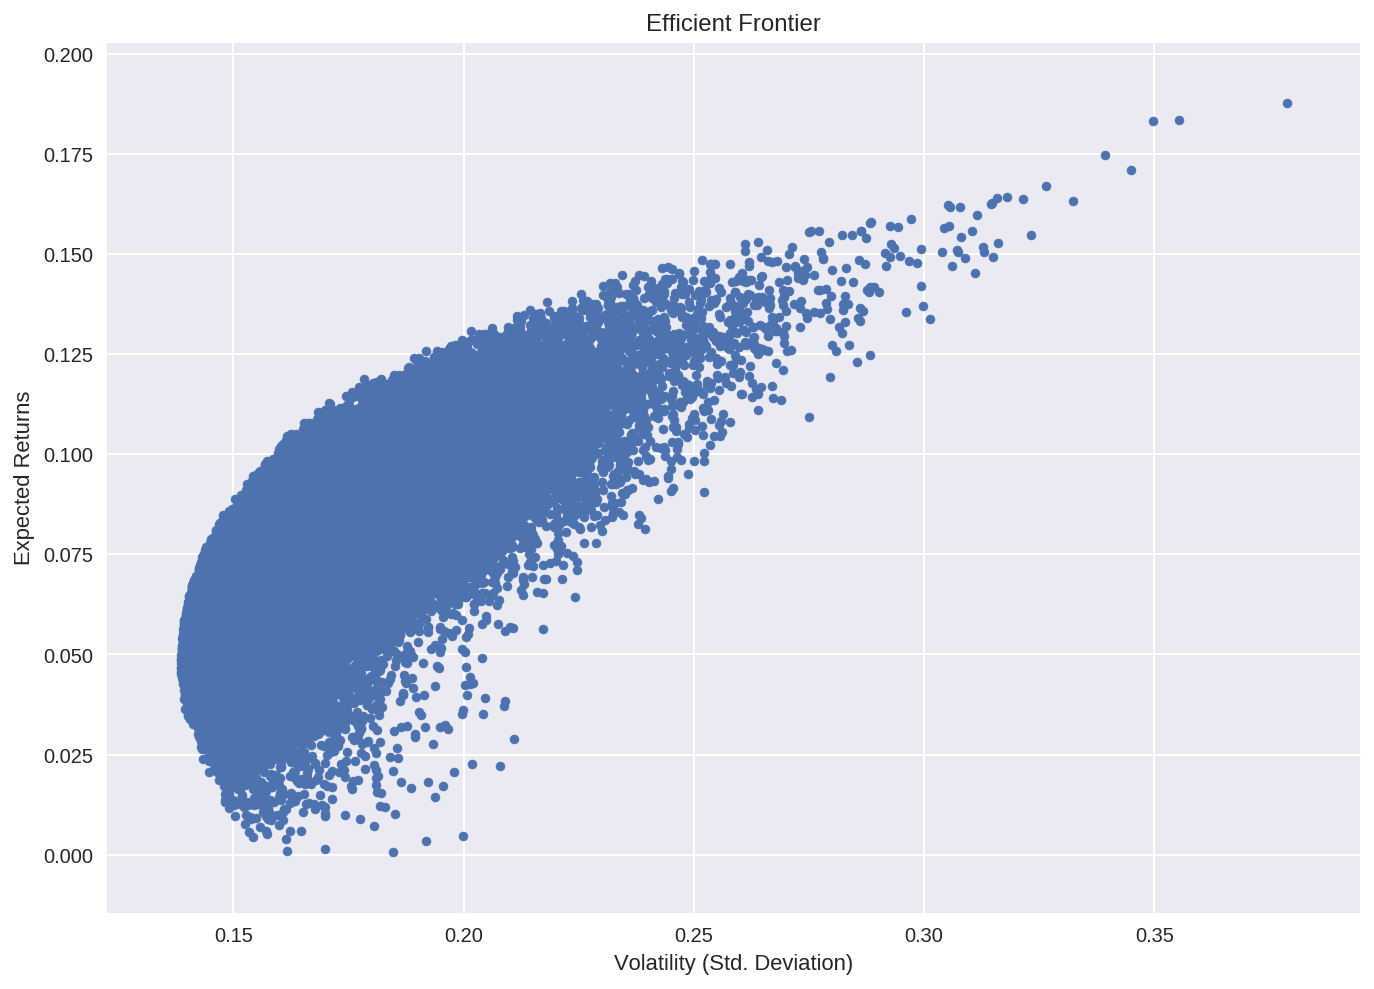

In [31]:
# plot the efficient frontier with a scatter plot
plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

# With Sharpe Ratio

-  If all points on the Efficient Frontier curve are optimal combinations, what is the optimal portfolio among the various optimal combinations? What would even the criteria for choosing this “best of the best” combinations?
- we gonna use 'Sharpe ratio' as choosing this best combination.
- Sharpe ratio is simply as a measure of the performance of an investment's return given its risk.  This ratio adjusts the returns of an investment which makes it possible to compare different investments on a scale that incorporates risk.
- Without this scale of comparison, it would be virtually impossible to compare different investments with different combinations and their accompanying risks and returns.

In [67]:
# 퀀들 Api에서 데이터를 로드
quandl.ApiConfig.api_key = 'INSERT YOUR API KEY HERE'
selected = ['CNP', 'F', 'WMT', 'GE', 'TSLA']
data = quandl.get_table('WIKI/PRICES', ticker = selected,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2014-1-1', 'lte': '2016-12-31' }, paginate=True)

#시각화와 데이터 웽글링을 위해서 새롭게 인덱스와 컬럼을 지정해준다.
clean = data.set_index('date')
table = clean.pivot(columns='ticker')

#수익률과 분산을 일별, 연별로 다시 만들어준다.
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 250

cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# 반복문을 돌면서 채워나갈 수익률, 분산, 샤프 지수, 가중치의 빈 리스트를 준비해둔다.
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# num_assets : 기업의 수이다. 5개
# num_portfolios : 몬테 카를로 시뮬레이션을 위해서 숫자를 임의로 지정해준다. 여기서는 5만개이다.
num_assets = len(selected)
num_portfolios = 50000

# 일관성있는 시뮬레이팅을 위해서, 랜덤 시드를 박아준다.
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
# 몬테 카를로 시뮬레이션이 구동되는 곳이다.
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    # 가중치가 랜덤으로 뽑혀서 비율로 변환되는 과정이다.
    returns = np.dot(weights, returns_annual)
    #각각의 일별 수익률의 평균에서 250일이 곱해진 즉, 연별 수익률에 가중치를 곱해서 포트폴리오 수익률로 만들어준다.
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    # 변동성 계산이다.
    sharpe = returns / volatility
    # 샤프 지수 계산이다.
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)
    # 빈리스트에 appending시켜 저장시킨다.

# 포트폴리오를 구성하는 요소인 수익률, 변동성, 샤프지수를 딕셔너리로 만들어준다.
# 딕셔너리의 키들은 나중에 만들 데이터 프레임의 컬럼이 된다.
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# 반복문이 우선 5개 돌고, 리스트 컴프리 핸션 안에서 5만개가 돈다. 이것은 각 컬럼마다 데이터가 5만개가 들어가는데,
# 위에서 한개의 stock_weights마다 랜덤 요소가 5개인 리스트를 만들었고, 각각의 인덱스가 각각의 회사를 의미하게 하는 것이다.
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# 늘어난 포트폴리오의 딕셔너리를 그대로 데이터 프레임으로 만들어준다.
df = pd.DataFrame(portfolio)

#컬럼을 명시해준다.
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

# 지정한 컬럼 순서대로 데이터 프레임을 정렬한다.
df = df[column_order]
df.shape

(50000, 8)

In [51]:
df.tail()

,Returns,Volatility,Sharpe Ratio,CNP Weight,F Weight,WMT Weight,GE Weight,TSLA Weight
49995,0.086426,0.170291,0.507521,0.357558,0.170924,0.097700,0.222875,0.150943
49996,0.093688,0.161602,0.579749,0.290100,0.035873,0.274062,0.201812,0.198154
49997,0.110022,0.193760,0.567827,0.402182,0.154606,0.135415,0.299237,0.008560
49998,0.066552,0.142114,0.468302,0.272302,0.072888,0.280416,0.076169,0.298225
49999,0.081267,0.176521,0.460381,0.261165,0.268568,0.111463,0.237871,0.120932


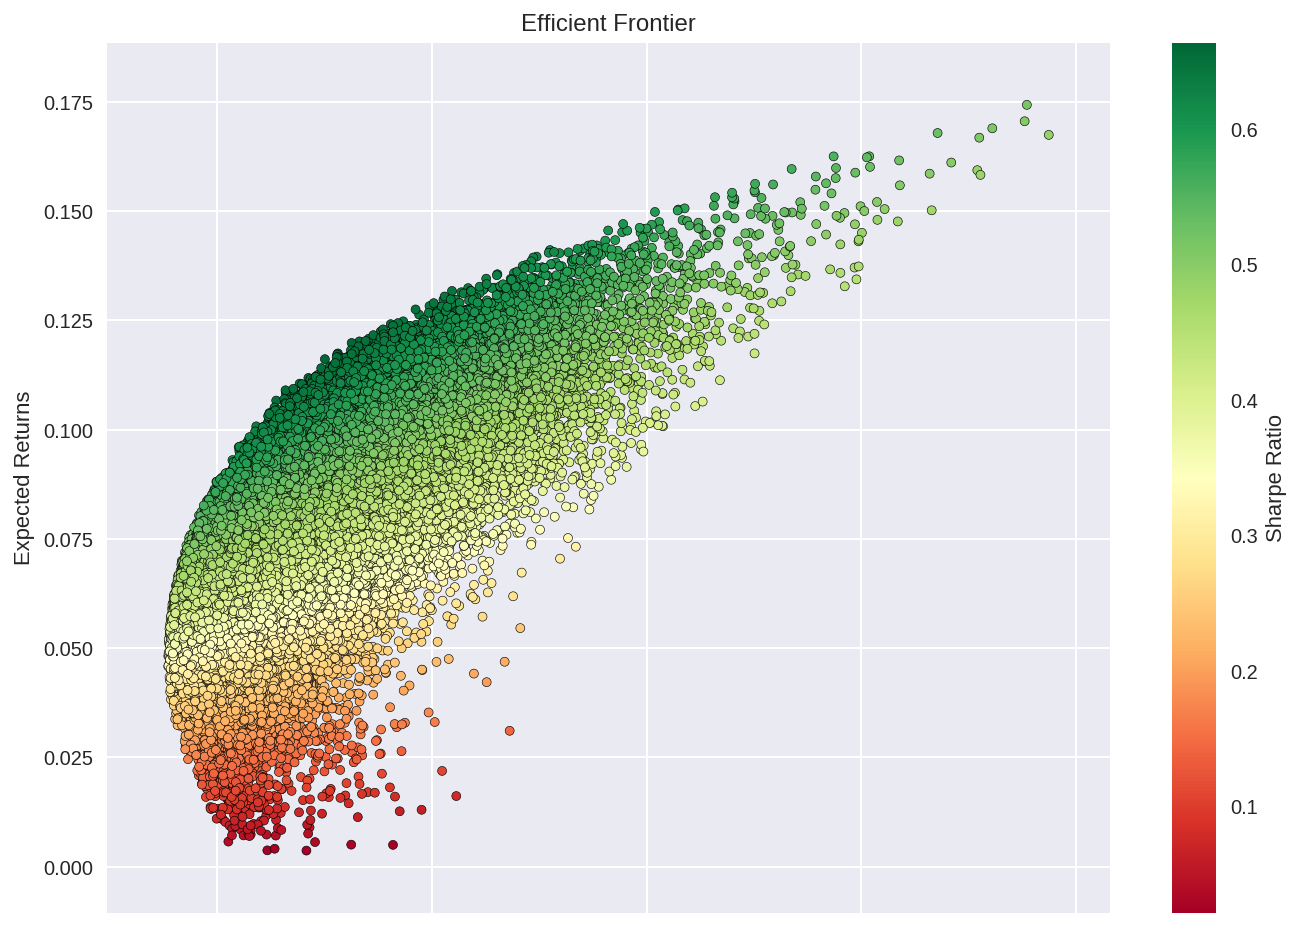

In [52]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [59]:
from IPython.display import display
display(sharpe_portfolio)
display(min_variance_port)

,Returns,Volatility,Sharpe Ratio,CNP Weight,F Weight,WMT Weight,GE Weight,TSLA Weight
31209,0.116145,0.175045,0.663514,0.37289,0.008482,0.404987,0.21145,0.00219


,Returns,Volatility,Sharpe Ratio,CNP Weight,F Weight,WMT Weight,GE Weight,TSLA Weight
17879,0.045828,0.138552,0.330761,0.240327,0.104659,0.25776,0.001487,0.395767


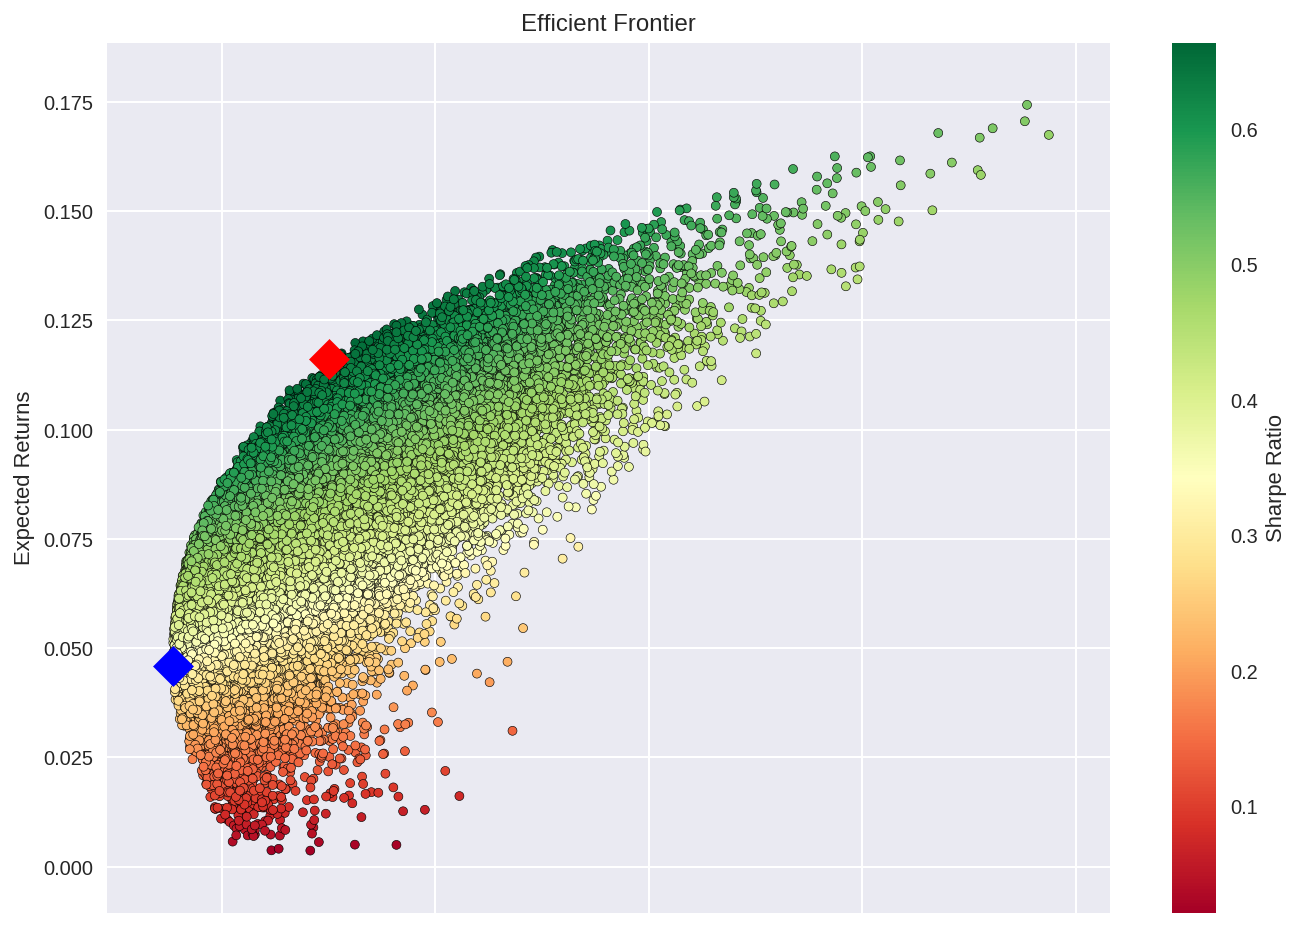

In [53]:
# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [54]:
# print the details of the 2 special portfolios
print(min_variance_port.T)
print(sharpe_portfolio.T)

                 17879
Returns       0.045828
Volatility    0.138552
Sharpe Ratio  0.330761
CNP Weight    0.240327
F Weight      0.104659
WMT Weight    0.257760
GE Weight     0.001487
TSLA Weight   0.395767
                 31209
Returns       0.116145
Volatility    0.175045
Sharpe Ratio  0.663514
CNP Weight    0.372890
F Weight      0.008482
WMT Weight    0.404987
GE Weight     0.211450
TSLA Weight   0.002190


- The most risk-averse investor would construct the minimum variance portfolio which has an expected return of `4.58%` with an accompanying expected volatility of `13.86%.`
- Investors seeking the maximum risk-adjusted return would opt for portfolio that with the maximum Sharpe ratio which has an expected return of `11.62%` with expected volatility pegged at `17.50%`

# Monte Carlo Simulation
- Broad class of computational algorithms that rely on repeated random sampling to obtain numerical results. 
- Their essential idea is using randomness to solve problems that might be deterministic in principle.
- They are often used in physical and mathematical problems and are most useful when it is difficult or impossible to use other approaches. 